# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [4]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()])
    transformed_dataset = datasets.ImageFolder(data_dir, transform)
    dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

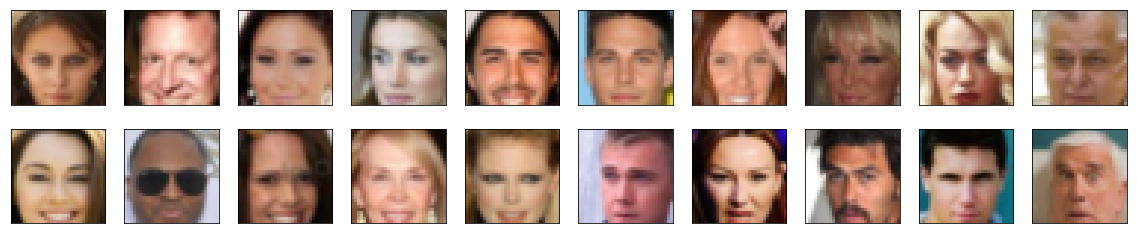

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    (min, max) = feature_range
    x = min + (max - min) * x
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8510)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper conv function copied from Deep GAN lesson.
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

        # 32x32
        self.c1 = conv(3, conv_dim, 4, batch_norm=False)
        #16x16
        self.c2 = conv(conv_dim, conv_dim * 2, 4)
        #8x8
        self.c3 = conv(conv_dim * 2, conv_dim * 4, 4)
        #4x4
        self.hidden_dim = 4
        self.fc = nn.Linear(self.hidden_dim * self.hidden_dim * conv_dim * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.c1(x), 0.2)
        x = F.leaky_relu(self.c2(x), 0.2)
        x = F.leaky_relu(self.c3(x), 0.2)
        x = x.view(-1, self.hidden_dim * self.hidden_dim * self.conv_dim * 4)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function copied from Deep GAN lecture.
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                    kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)


In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        self.hidden_dim = 4
        self.fc = nn.Linear(z_size, self.hidden_dim * self.hidden_dim * conv_dim * 4)

        self.c1 = deconv(conv_dim * 4,  conv_dim * 2, 4)
        self.c2 = deconv(conv_dim * 2, conv_dim, 4)
        self.c3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 4, self.hidden_dim, self.hidden_dim)
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.c3(x)
        x = F.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [41]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (c1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (c2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (c1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [43]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if smooth:
        labels *= 0.9
        
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [44]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [45]:
import os

def checkpoint(iteration, D, G, checkpoint_dir='checkpoints'):
    """Saves the parameters of both the generator G and the discriminator D.
        """
    G_path = os.path.join(checkpoint_dir, str(iteration) + '-G.pkl')
    D_path = os.path.join(checkpoint_dir, str(iteration) + '-D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

In [46]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop

    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # real
            d_out = D(real_images)
            d_real_loss = real_loss(d_out)
            
            # fake
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            d_out = D(fake_images)
            d_fake_loss = fake_loss(d_out)
            
            # loss, backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # prep G input
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            # generate fake images and create loss using D
            fake_images = G(z)
            d_out = D(fake_images)
            g_loss = real_loss(d_out)
            
            # backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        checkpoint(epoch, D, G)

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [52]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.9726 | g_loss: 2.2434
Epoch [    1/  100] | d_loss: 1.0293 | g_loss: 1.0761
Epoch [    1/  100] | d_loss: 0.8341 | g_loss: 1.6705
Epoch [    1/  100] | d_loss: 1.2874 | g_loss: 0.6715
Epoch [    1/  100] | d_loss: 0.8403 | g_loss: 1.6126
Epoch [    1/  100] | d_loss: 0.9704 | g_loss: 1.8295
Epoch [    1/  100] | d_loss: 1.2163 | g_loss: 0.8114
Epoch [    1/  100] | d_loss: 0.9851 | g_loss: 1.3253
Epoch [    1/  100] | d_loss: 1.2955 | g_loss: 2.9066
Epoch [    1/  100] | d_loss: 0.8379 | g_loss: 2.2422
Epoch [    1/  100] | d_loss: 0.9602 | g_loss: 2.2656
Epoch [    1/  100] | d_loss: 0.9408 | g_loss: 2.0585
Epoch [    1/  100] | d_loss: 1.2225 | g_loss: 0.9574
Epoch [    1/  100] | d_loss: 1.1318 | g_loss: 1.9447
Epoch [    1/  100] | d_loss: 1.0855 | g_loss: 1.1741
Epoch [    2/  100] | d_loss: 1.0960 | g_loss: 1.8917
Epoch [    2/  100] | d_loss: 0.9878 | g_loss: 1.3840
Epoch [    2/  100] | d_loss: 1.1956 | g_loss: 0.8565
Epoch [    2/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.9507 | g_loss: 3.0425
Epoch [   11/  100] | d_loss: 0.6943 | g_loss: 2.3389
Epoch [   11/  100] | d_loss: 0.5609 | g_loss: 2.7098
Epoch [   11/  100] | d_loss: 0.7285 | g_loss: 2.1009
Epoch [   11/  100] | d_loss: 0.7147 | g_loss: 1.9790
Epoch [   11/  100] | d_loss: 0.4736 | g_loss: 2.8942
Epoch [   11/  100] | d_loss: 0.7568 | g_loss: 2.3110
Epoch [   11/  100] | d_loss: 0.6801 | g_loss: 2.0693
Epoch [   11/  100] | d_loss: 0.6779 | g_loss: 3.2484
Epoch [   11/  100] | d_loss: 0.8246 | g_loss: 3.0543
Epoch [   11/  100] | d_loss: 0.6539 | g_loss: 2.1403
Epoch [   11/  100] | d_loss: 1.2789 | g_loss: 1.8289
Epoch [   11/  100] | d_loss: 0.7934 | g_loss: 2.9435
Epoch [   12/  100] | d_loss: 0.7693 | g_loss: 2.7106
Epoch [   12/  100] | d_loss: 0.7795 | g_loss: 3.5517
Epoch [   12/  100] | d_loss: 0.4513 | g_loss: 3.5147
Epoch [   12/  100] | d_loss: 0.5360 | g_loss: 2.3283
Epoch [   12/  100] | d_loss: 0.4655 | g_loss: 2.2484
Epoch [   12/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.6422 | g_loss: 4.4028
Epoch [   21/  100] | d_loss: 0.4600 | g_loss: 3.0148
Epoch [   21/  100] | d_loss: 0.7711 | g_loss: 4.2755
Epoch [   21/  100] | d_loss: 0.6962 | g_loss: 3.2893
Epoch [   21/  100] | d_loss: 0.6943 | g_loss: 3.3957
Epoch [   21/  100] | d_loss: 0.5526 | g_loss: 3.8744
Epoch [   21/  100] | d_loss: 1.2703 | g_loss: 3.0567
Epoch [   21/  100] | d_loss: 0.4175 | g_loss: 2.6757
Epoch [   21/  100] | d_loss: 0.5199 | g_loss: 2.8629
Epoch [   21/  100] | d_loss: 0.5012 | g_loss: 3.1355
Epoch [   21/  100] | d_loss: 0.9140 | g_loss: 1.5740
Epoch [   22/  100] | d_loss: 0.6601 | g_loss: 1.6451
Epoch [   22/  100] | d_loss: 0.6647 | g_loss: 2.9905
Epoch [   22/  100] | d_loss: 0.4250 | g_loss: 2.5300
Epoch [   22/  100] | d_loss: 0.5084 | g_loss: 3.4923
Epoch [   22/  100] | d_loss: 0.4843 | g_loss: 3.0260
Epoch [   22/  100] | d_loss: 0.5956 | g_loss: 3.5189
Epoch [   22/  100] | d_loss: 0.5590 | g_loss: 3.7536
Epoch [   22/  100] | d_loss

Epoch [   31/  100] | d_loss: 0.6068 | g_loss: 4.1510
Epoch [   31/  100] | d_loss: 0.4017 | g_loss: 4.0451
Epoch [   31/  100] | d_loss: 0.3870 | g_loss: 3.4645
Epoch [   31/  100] | d_loss: 0.3511 | g_loss: 5.3098
Epoch [   31/  100] | d_loss: 0.4988 | g_loss: 2.8878
Epoch [   31/  100] | d_loss: 0.3982 | g_loss: 3.3563
Epoch [   31/  100] | d_loss: 0.5259 | g_loss: 4.2437
Epoch [   31/  100] | d_loss: 0.5910 | g_loss: 1.4267
Epoch [   31/  100] | d_loss: 0.6390 | g_loss: 2.0664
Epoch [   32/  100] | d_loss: 0.5305 | g_loss: 2.8947
Epoch [   32/  100] | d_loss: 0.7104 | g_loss: 3.6083
Epoch [   32/  100] | d_loss: 1.1261 | g_loss: 3.0534
Epoch [   32/  100] | d_loss: 1.4712 | g_loss: 3.9586
Epoch [   32/  100] | d_loss: 0.5687 | g_loss: 3.3209
Epoch [   32/  100] | d_loss: 0.4572 | g_loss: 3.0523
Epoch [   32/  100] | d_loss: 0.5420 | g_loss: 3.7100
Epoch [   32/  100] | d_loss: 0.3706 | g_loss: 4.7582
Epoch [   32/  100] | d_loss: 0.5879 | g_loss: 1.9410
Epoch [   32/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.4463 | g_loss: 3.8940
Epoch [   41/  100] | d_loss: 0.3622 | g_loss: 5.4759
Epoch [   41/  100] | d_loss: 0.4445 | g_loss: 2.8655
Epoch [   41/  100] | d_loss: 0.4748 | g_loss: 2.7717
Epoch [   41/  100] | d_loss: 0.5926 | g_loss: 1.6474
Epoch [   41/  100] | d_loss: 0.3602 | g_loss: 5.0566
Epoch [   41/  100] | d_loss: 0.4044 | g_loss: 3.6370
Epoch [   42/  100] | d_loss: 0.4049 | g_loss: 3.4242
Epoch [   42/  100] | d_loss: 0.4133 | g_loss: 3.1332
Epoch [   42/  100] | d_loss: 1.1364 | g_loss: 1.9086
Epoch [   42/  100] | d_loss: 1.3950 | g_loss: 3.9213
Epoch [   42/  100] | d_loss: 0.5662 | g_loss: 3.0765
Epoch [   42/  100] | d_loss: 0.4841 | g_loss: 3.8990
Epoch [   42/  100] | d_loss: 0.3671 | g_loss: 5.4952
Epoch [   42/  100] | d_loss: 0.4177 | g_loss: 3.6469
Epoch [   42/  100] | d_loss: 0.4375 | g_loss: 3.7662
Epoch [   42/  100] | d_loss: 0.6895 | g_loss: 3.0275
Epoch [   42/  100] | d_loss: 0.4971 | g_loss: 3.6253
Epoch [   42/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.3989 | g_loss: 3.3931
Epoch [   51/  100] | d_loss: 0.3803 | g_loss: 3.8271
Epoch [   51/  100] | d_loss: 0.4545 | g_loss: 3.4178
Epoch [   51/  100] | d_loss: 0.5976 | g_loss: 2.2085
Epoch [   51/  100] | d_loss: 0.4444 | g_loss: 3.6121
Epoch [   52/  100] | d_loss: 0.4298 | g_loss: 3.1157
Epoch [   52/  100] | d_loss: 0.4630 | g_loss: 2.6620
Epoch [   52/  100] | d_loss: 0.4406 | g_loss: 4.7402
Epoch [   52/  100] | d_loss: 0.6304 | g_loss: 2.8175
Epoch [   52/  100] | d_loss: 0.4965 | g_loss: 2.8412
Epoch [   52/  100] | d_loss: 0.3652 | g_loss: 4.5751
Epoch [   52/  100] | d_loss: 0.4237 | g_loss: 3.4790
Epoch [   52/  100] | d_loss: 0.5117 | g_loss: 2.2470
Epoch [   52/  100] | d_loss: 0.3923 | g_loss: 5.2128
Epoch [   52/  100] | d_loss: 0.5831 | g_loss: 2.0804
Epoch [   52/  100] | d_loss: 0.3779 | g_loss: 4.2324
Epoch [   52/  100] | d_loss: 2.3573 | g_loss: 7.5648
Epoch [   52/  100] | d_loss: 0.5058 | g_loss: 2.7357
Epoch [   52/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.4027 | g_loss: 3.7159
Epoch [   61/  100] | d_loss: 0.5892 | g_loss: 3.7451
Epoch [   61/  100] | d_loss: 0.5371 | g_loss: 3.2697
Epoch [   62/  100] | d_loss: 0.5282 | g_loss: 2.1636
Epoch [   62/  100] | d_loss: 0.5172 | g_loss: 4.7498
Epoch [   62/  100] | d_loss: 0.4341 | g_loss: 4.7514
Epoch [   62/  100] | d_loss: 0.4517 | g_loss: 5.4685
Epoch [   62/  100] | d_loss: 0.4788 | g_loss: 3.7396
Epoch [   62/  100] | d_loss: 0.3675 | g_loss: 4.7490
Epoch [   62/  100] | d_loss: 0.9086 | g_loss: 3.1162
Epoch [   62/  100] | d_loss: 0.5509 | g_loss: 4.1521
Epoch [   62/  100] | d_loss: 0.4668 | g_loss: 2.7077
Epoch [   62/  100] | d_loss: 0.4782 | g_loss: 2.5698
Epoch [   62/  100] | d_loss: 0.4930 | g_loss: 2.8982
Epoch [   62/  100] | d_loss: 0.4586 | g_loss: 3.0293
Epoch [   62/  100] | d_loss: 0.4854 | g_loss: 3.1533
Epoch [   62/  100] | d_loss: 0.3508 | g_loss: 5.4107
Epoch [   62/  100] | d_loss: 0.4364 | g_loss: 3.7839
Epoch [   63/  100] | d_loss

Epoch [   71/  100] | d_loss: 0.4077 | g_loss: 4.3630
Epoch [   72/  100] | d_loss: 0.3693 | g_loss: 4.9423
Epoch [   72/  100] | d_loss: 0.3903 | g_loss: 3.8694
Epoch [   72/  100] | d_loss: 0.3595 | g_loss: 5.0686
Epoch [   72/  100] | d_loss: 0.4161 | g_loss: 3.2697
Epoch [   72/  100] | d_loss: 0.4136 | g_loss: 3.8076
Epoch [   72/  100] | d_loss: 0.5471 | g_loss: 2.9319
Epoch [   72/  100] | d_loss: 0.3557 | g_loss: 5.9187
Epoch [   72/  100] | d_loss: 0.3591 | g_loss: 4.3824
Epoch [   72/  100] | d_loss: 0.4702 | g_loss: 3.0609
Epoch [   72/  100] | d_loss: 0.3544 | g_loss: 5.9940
Epoch [   72/  100] | d_loss: 0.5496 | g_loss: 4.2379
Epoch [   72/  100] | d_loss: 0.3820 | g_loss: 4.0698
Epoch [   72/  100] | d_loss: 0.7513 | g_loss: 2.1354
Epoch [   72/  100] | d_loss: 0.4404 | g_loss: 3.8790
Epoch [   72/  100] | d_loss: 1.2506 | g_loss: 2.5906
Epoch [   73/  100] | d_loss: 0.9483 | g_loss: 3.8066
Epoch [   73/  100] | d_loss: 0.4668 | g_loss: 3.7166
Epoch [   73/  100] | d_loss

Epoch [   82/  100] | d_loss: 0.3798 | g_loss: 3.6613
Epoch [   82/  100] | d_loss: 2.2740 | g_loss: 0.6742
Epoch [   82/  100] | d_loss: 0.3604 | g_loss: 5.4254
Epoch [   82/  100] | d_loss: 0.4194 | g_loss: 5.0978
Epoch [   82/  100] | d_loss: 0.5107 | g_loss: 2.6008
Epoch [   82/  100] | d_loss: 0.3843 | g_loss: 6.2565
Epoch [   82/  100] | d_loss: 0.4045 | g_loss: 3.8998
Epoch [   82/  100] | d_loss: 0.3653 | g_loss: 4.2610
Epoch [   82/  100] | d_loss: 0.3726 | g_loss: 4.0587
Epoch [   82/  100] | d_loss: 0.3650 | g_loss: 6.7383
Epoch [   82/  100] | d_loss: 0.3688 | g_loss: 5.1853
Epoch [   82/  100] | d_loss: 0.4863 | g_loss: 2.8652
Epoch [   82/  100] | d_loss: 0.3833 | g_loss: 3.8931
Epoch [   82/  100] | d_loss: 0.3615 | g_loss: 5.3255
Epoch [   83/  100] | d_loss: 0.4236 | g_loss: 4.0073
Epoch [   83/  100] | d_loss: 1.1992 | g_loss: 4.5729
Epoch [   83/  100] | d_loss: 0.6533 | g_loss: 3.3755
Epoch [   83/  100] | d_loss: 0.3728 | g_loss: 3.7692
Epoch [   83/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.3495 | g_loss: 5.8269
Epoch [   92/  100] | d_loss: 0.3647 | g_loss: 4.5270
Epoch [   92/  100] | d_loss: 0.4612 | g_loss: 3.8278
Epoch [   92/  100] | d_loss: 0.3687 | g_loss: 5.2464
Epoch [   92/  100] | d_loss: 0.6088 | g_loss: 1.6231
Epoch [   92/  100] | d_loss: 0.3825 | g_loss: 4.2339
Epoch [   92/  100] | d_loss: 0.4421 | g_loss: 3.9498
Epoch [   92/  100] | d_loss: 0.3943 | g_loss: 3.8095
Epoch [   92/  100] | d_loss: 0.6318 | g_loss: 2.1073
Epoch [   92/  100] | d_loss: 0.4309 | g_loss: 4.2180
Epoch [   92/  100] | d_loss: 0.4642 | g_loss: 3.6731
Epoch [   92/  100] | d_loss: 0.3816 | g_loss: 3.9846
Epoch [   93/  100] | d_loss: 0.3774 | g_loss: 5.4556
Epoch [   93/  100] | d_loss: 0.3510 | g_loss: 5.5603
Epoch [   93/  100] | d_loss: 0.4106 | g_loss: 4.3155
Epoch [   93/  100] | d_loss: 0.4053 | g_loss: 3.0646
Epoch [   93/  100] | d_loss: 0.5974 | g_loss: 4.0392
Epoch [   93/  100] | d_loss: 0.3747 | g_loss: 4.2214
Epoch [   93/  100] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

### Exp 1. conv_dim = 32 after 1 epoch

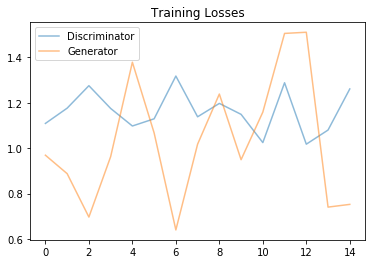

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Exp 2 conv_dim = 64 after 1 epoch

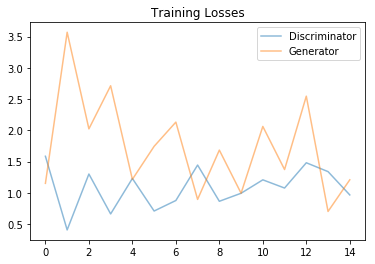

In [40]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Exp 3 conv_dim = 128 after 1 epoch

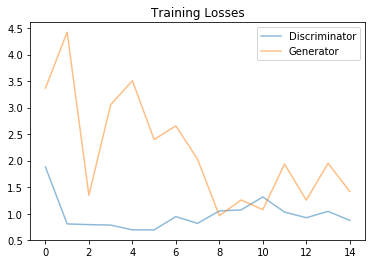

In [48]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Exp 4 100 epochs on conv_dim 128 like DCGAN

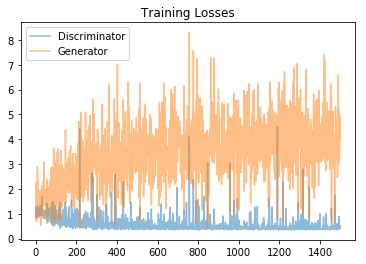

In [53]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [49]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

### 1 Epoch on conv_dim = 128

In [50]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

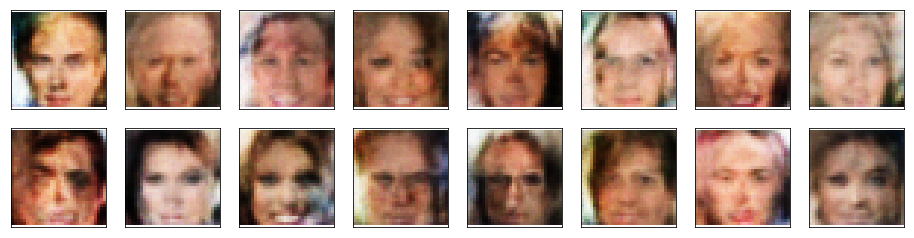

In [51]:
_ = view_samples(-1, samples)

### 100 Epochs on conv_dim = 128

In [54]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

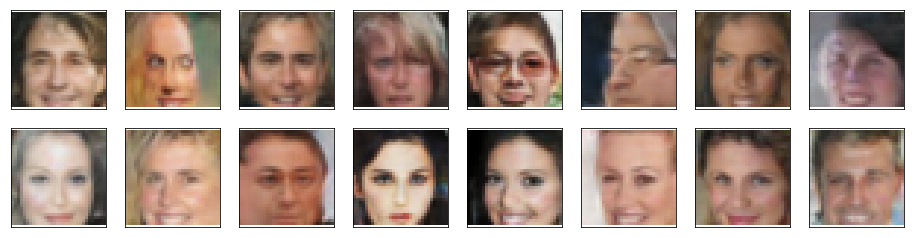

In [55]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
1. The resolution is pretty low. I could increase the size of the model input image to 64x64 like the original paper. 
2. I see only profile head photos with makeups for women. I think it's probably because most celebry face photos are perfect with makeup and have similar head poses. I could try increase the training dataset with normal people faces in varying head poses.
3. I see that three face photos did not complete the face, and I see that the generator's loss is still increasing even throughout the end of the last several epochs. This probably means that I could let the model to learn for a greater number of epochs like 1000 until it finally flattens. Or, the training dataset size could be increased with either augmentation or by adding more real photos. This might also mean that I may need to try out different optimizer like SGD with a momentum to overcome getting stuck in a local minima.
4. I don't see dark faces. The training dataset seems to be biased in favor of bright faces.



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.